# Transformer Baseline

In [1]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# save checkpoints using orbax
from pathlib import Path

# local imports
import models.models as models
import utils.generation as generation
import utils.eval as eval

# utilities
# Import our new utilities
from utils import (
    load_config,
    print_config,
    plot_training_curves,
    analyze_training_performance,
    save_collected_checkpoints,
    logger,
    test_checkpoint,
    load_checkpoint,
)


## Load Data

In [3]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text_full = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

train_ratio = 0.95
N = len(train_text_full)
cut = int(N * train_ratio)

train_text = train_text_full[:cut]  # training text
val_text = train_text_full[cut:]  # validation text
# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of validation text: {len(val_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 85_500_000 characters
Length of validation text: 4_500_000 characters
Length of test text: 5_000_000 characters


In [4]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}


def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [5]:
# encode the text
train_text_int = encode(train_text)
val_text_int = encode(val_text)
test_text_int = encode(test_text)

In [6]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

cial experiences and improve the well being of the whole a moderate form of this occurrence is called a social movement while a 

ritorial sea one two nautical miles two two km climate temperate humid and overcast mild windy winters and cool summers terrain 

n females is possible hearing deficits eye problems cataracts strabismus near and far sightedness alzheimer s disease there is s

 evidence that miss whitman s mother intervened and did much to derail their relationship according to poe s own account he atte

hamorro people the battle of guam started on july two one one nine four four with american troops landing on the island and guam



## Load Conifguration

In [7]:
CONFIG_PATH = "./configs/baseline.yaml"
# Load configuration
config = load_config(CONFIG_PATH)
print_config(config)

# Initialize random seed
key = jax.random.key(config.training.seed)


CONFIGURATION
model_name: Baseline
model:
  vocab_size: 27
  d_model: 256
  n_heads: 4
  n_layers: 4
  max_len: 128
  mlp_ratio: 4
  emb_dropout: 0.1
  mlp_dropout: 0.1
  attn_dropout: 0.1
  resid_dropout: 0.1
loss:
  LABEL_SMOOTHING: True
  ls_eps: 0.05
  entropy_lambda: 0.0
training:
  batch_size: 128
  sequence_length: 128
  learning_rate: 0.0003
  epochs: 10
  eval_interval: 500
  warmup_iters: 2
  stage_checkpoint_interval: 10000
  seed: 4212
output:
  checkpoint_dir: ./checkpoints
  results_dir: ./runs



# Create a basic Transformer model

In [8]:
def create_train_state(rng, config):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(
        vocab_size=config.model.vocab_size,
        d_model=config.model.d_model,
        n_layers=config.model.n_layers,
        n_heads=config.model.n_heads,
        max_len=config.model.max_len,
        mlp_ratio=config.model.mlp_ratio,
        emb_dropout=config.model.emb_dropout,
        mlp_dropout=config.model.mlp_dropout,
        attn_dropout=config.model.attn_dropout,
        resid_dropout=config.model.resid_dropout
    )
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, config.model.max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy, deterministic=True)["params"]
    return model, params


def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [9]:
model, params = create_train_state(key, config)
num_params = count_params(params)
print(f"Model created: {config.model_name}")
print(f"Number of parameters: {num_params:_}")

Model created: Baseline
Number of parameters: 3_202_048


In [10]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch, deterministic=True)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


## Loss function

In [11]:
@jax.jit
def loss_and_metrics(logits, targets):

    B, T, V = logits.shape

    # position weights mode
    # linear: w(t) = 0.3 + 0.7 * (t / T)
    # sqrt: w(t) = 0.1 + 0.9 * sqrt(t / T)
    # none: w(t) = 1.0
    tail_scheme = "linear"

    if config.loss.LABEL_SMOOTHING and config.loss.ls_eps > 0.0:
        tgt = jax.nn.one_hot(targets, V)
        tgt = (1.0 - config.loss.ls_eps) * tgt + (config.loss.ls_eps / V)
        per_pos_ce = optax.softmax_cross_entropy(logits, tgt)
    else:
        per_pos_ce = optax.softmax_cross_entropy_with_integer_labels(
            logits.reshape(-1, V), targets.reshape(-1)
        ).reshape(B, T)

    # Position weights: emphasize later positions, but don't discard early ones
    if tail_scheme == "linear":
        w = jnp.linspace(0.3, 1.0, T)
    elif tail_scheme == "sqrt":
        w = 0.1 + 0.9 * jnp.sqrt(jnp.linspace(0.0, 1.0, T))
    else:
        w = jnp.ones((T,))
    w = w[None, :]

    # Weighted loss
    loss_weighted = (per_pos_ce * w).sum() / (B * w.sum())

    # Entropy bonus to encourage less-peaked distributions
    if config.loss.entropy_lambda > 0.0:
        logp = jax.nn.log_softmax(logits, axis=-1)
        p = jnp.exp(logp)
        entropy = -(p * logp).sum(-1).mean()
        train_loss = loss_weighted - config.loss.entropy_lambda * entropy
    else:
        train_loss = loss_weighted

    # Metrics for curve comparison (do not involved in backprop)
    # Mean CE over all positions (unweighted, for alignment with literature/old results)
    loss_all = eval.loss_all(logits, targets)
    loss_last = eval.cross_entropy_last_token_only(logits, targets)
    acc_all, acc_last = eval.accuracy(logits, targets)
    perplexity, avg_loss = eval.perplexity(logits, targets)
    bpc = eval.bits_per_character(avg_loss)
    avg_entropy, entropy_by_position = eval.prediction_entropy(logits)

    # ECE
    ece, calibration_data = eval.expected_calibration_error(logits, targets)

    metrics = {
        "loss_train": train_loss,
        "loss_all": loss_all,
        "loss_last": loss_last,
        "acc": acc_all,
        "acc_last": acc_last,
        "perplexity": perplexity,
        "bpc": bpc,
        "pred_entropy": avg_entropy,
        "ece": [ece, calibration_data],
    }

    return train_loss, metrics


## Optimization step

In [12]:
# create an update function
def train_step(params, opt_state, x, y, tx, rng):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """

    rng, dropout_rng = jax.random.split(rng)

    def loss_fn(params):
        logits = model.apply(
            {"params": params},
            x,
            deterministic=False,
            rngs={"dropout": dropout_rng},
        )
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics


# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

## Batch creation

In [13]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

## Optimizer creation

In [14]:
# learning rate scheduler
lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=config.training.learning_rate,
    warmup_steps=config.training.warmup_iters,
    decay_steps=max(1, config.training.epochs - config.training.warmup_iters),
    end_value=0.0,
)

# Create AdamW optimizer (Optax)
tx = optax.chain(
    # gradient clipping (optiaonal)
    optax.clip_by_global_norm(1.0),
    optax.adamw(
        learning_rate=lr_schedule,
        b1=0.9,
        b2=0.95,
        eps=1e-8,
        weight_decay=0.1,
    ),
)

# Initialize optimizer state for current params
opt_state = tx.init(params)

print("Optimizer initialized: AdamW with warmup-cosine schedule")

Optimizer initialized: AdamW with warmup-cosine schedule


## Model Training

In [15]:
CKPT_DIR = Path(f"{config.output.checkpoint_dir}/{config.model_name}").resolve()
CKPT_DIR.mkdir(parents=True, exist_ok=True)

STAGE_DIR = CKPT_DIR / 'stage'
BEST_DIR = CKPT_DIR / 'best'
STAGE_DIR.mkdir(exist_ok=True)
BEST_DIR.mkdir(exist_ok=True)

print(f"Checkpoint directory: {CKPT_DIR}")

Checkpoint directory: /Users/hanyueyu/Desktop/未命名/checkpoints/Baseline


In [16]:
metrics_logger = logger.Logger(config.training.epochs)
print(f"Logger initialized: {metrics_logger}")

time_train_history = []
time_val_history = []

checkpoints_to_save = {
    'stage': [],
    'best_loss_all': None,
    'best_acc': None,
    'best_acc_last': None,
    'best_perplexity': None,
}

rng = jax.random.PRNGKey(config.training.seed)

print("Training initialization complete")
print(f"- Number of Epochs: {config.training.epochs:,}")
print(f"- Batch size: {config.training.batch_size}")
print(f"- Eval interval: {config.training.eval_interval}")

Logger initialized: Logger(train_steps=0, eval_steps=0)
Training initialization complete
- Number of Epochs: 10
- Batch size: 128
- Eval interval: 500


In [17]:
time_start = time.time()
for it in range(config.training.epochs):
    batch = get_batch(train_text_int, config.training.batch_size, config.training.sequence_length)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx, rng)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new

    # step_count = get_step_count(opt_state)
    lr = 1

    metrics_logger.log_train(metrics, lr)

    time_train_history.append(time.time() - time_start)

    if it % config.training.eval_interval == 0 or it == config.training.epochs - 1:
        time_since_start = time.time() - time_start

        # compute loss on validation set
        B_val, T_val = 1024, 32
        val_batch = get_batch(val_text_int, B_val, T_val)
        val_input, val_target = val_batch[0], val_batch[1]
        val_logits = model.apply({"params": params}, val_input, deterministic=True)

        # validation metrics
        val_weighted_loss, val_metrics = loss_and_metrics(val_logits, val_target)

        # record validation metrics
        metrics_logger.log_eval(it, val_metrics)
        time_val_history.append(time_since_start)

        # print validation metrics
        metrics_logger.print_metrics(time_since_start)

        is_best_loss_all, is_best_acc, is_best_acc_last, is_best_perplexity = metrics_logger.isBest(val_metrics)

        # save checkpoints
        checkpoint_state = {
            'params': params,
            'opt_state': opt_state,
            'rng': rng,
            'step': it,
            'val_loss': float(val_metrics['loss_all']),
            'val_acc': float(val_metrics['acc']),
            'val_acc_last': float(val_metrics['acc_last']),
        }

        if (it + 1) % config.training.stage_checkpoint_interval == 0 or (it + 1) == config.training.epochs:
            checkpoints_to_save['stage'].append((it, checkpoint_state.copy()))
            print(f"\t \t Saved stage checkpoint @ {it:,}")

        if is_best_loss_all:
            checkpoints_to_save['best_loss_all'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best loss checkpoint at iteration {it}...")

        if is_best_acc:
            checkpoints_to_save['best_acc'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best accuracy checkpoint at iteration {it}...")

        if is_best_acc_last:
            checkpoints_to_save['best_acc_last'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best last-character accuracy checkpoint at iteration {it}...")

        if is_best_perplexity:
            checkpoints_to_save['best_perplexity'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best perplexity checkpoint at iteration {it}...")

total_time = time.time() - time_start


iteration 0  time: 3.1 seconds
	 	 learning rate: 1.000000
	 	 loss (weighted train): 3.5052
	 	 loss (train :: test): 3.4982 :: 3.5026
	 	 loss (last character): 3.5026
	 	 accuracy: 4.4%
	 	 accuracy (last character): 4.7%
	 	 perplexity: 33.2021
	 	 bits-per-character: 5.0532
	 	 ECE: 0.1232
	 	 pred_entropy: 2.8775
	 	 Saving best loss checkpoint at iteration 0...
	 	 Saving best accuracy checkpoint at iteration 0...
	 	 Saving best last-character accuracy checkpoint at iteration 0...
	 	 Saving best perplexity checkpoint at iteration 0...

iteration 9  time: 6.4 seconds
	 	 learning rate: 1.000000
	 	 loss (weighted train): 2.9378
	 	 loss (train :: test): 2.8862 :: 2.8637
	 	 loss (last character): 2.8371
	 	 accuracy: 17.2%
	 	 accuracy (last character): 17.7%
	 	 perplexity: 17.5261
	 	 bits-per-character: 4.1314
	 	 ECE: 0.1232
	 	 pred_entropy: 2.7794
	 	 Saved stage checkpoint @ 9
	 	 Saving best loss checkpoint at iteration 9...
	 	 Saving best accuracy checkpoint at itera

In [18]:
save_collected_checkpoints(checkpoints_to_save, STAGE_DIR, BEST_DIR)

SAVING CHECKPOINTS
	 Saving stage checkpoint 1 (step 9)...
	 Saved (loss: 2.8637)
	 Saving best loss checkpoint (step 9)...


	 Saved (loss: 2.8637)
	 Saving best accuracy checkpoint (step 9)...


	 Saved (acc: 17.22%)
	 Saving best last-char accuracy checkpoint (step 9)...
	 Saved (acc_last: 17.68%)
	 Saving best perplexity checkpoint (step 9)...
	 Saved (loss: 2.8637)
ALL CHECKPOINTS SAVED


## Performance Analysis

In [19]:
results_dir = Path(f"{config.output.results_dir}/{config.model_name}").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

results = analyze_training_performance(
    metrics_logger=metrics_logger,
    total_time=total_time,
    niter=config.training.epochs,
    n_final=10,
    save_results=True,
    results_path=str(results_dir / 'training_results.json')
)


PERFORMANCE ANALYSIS

Best Test Loss:    2.8637  (at iteration 9)
Best Last Char Loss:    2.8371  (at iteration 9)
Best Test Acc:     17.22%  (at iteration 9)
Best Last Char Acc: 17.68%  (at iteration 9)

Final Average (last 10 checkpoints):
  Test Loss:       3.1832 ± 0.3195
  Last Char Loss:  3.1699 ± 0.3328
  Test Accuracy:   10.82% ± 6.40%
  Last Char Acc:   11.18% ± 6.49%

Training Time:
  Total:           28.3 seconds (0.5 minutes)
  Per Iteration:   2.8254 seconds
  Total Iterations: 10

Convergence Analysis:
  Still Improving:    N/A (insufficient data)

✓ Results saved to '/Users/hanyueyu/Desktop/未命名/runs/Baseline/training_results.json'


## Loss Ploting


Figure saved to '/Users/hanyueyu/Desktop/未命名/runs/Baseline/training_curves.pdf'


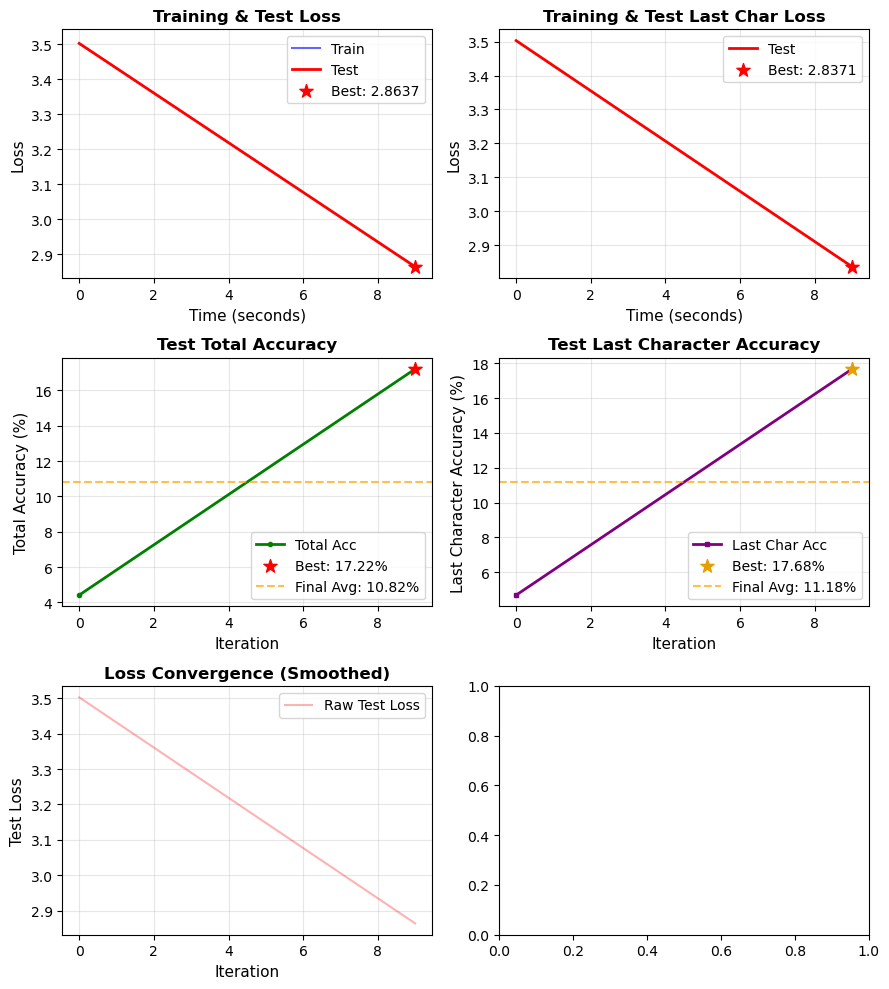

In [20]:
plot_training_curves(
    metrics_logger=metrics_logger,
    save_path=str(results_dir / 'training_curves.pdf')
)

## Evaluate

In [ ]:
prompt = "hello my fri"
gen_len = 1000
temperature = 0.7
sample = True
seed = 4212
self_belu_n_grams = 4
self_belu_n_samples = 20

checkpoint_types = [
    ('best_loss_all_', 'Best Loss'),
    ('best_acc_total_', 'Best Accuracy'),
    ('best_acc_last_', 'Best Last-Char Accuracy'),
    ('best_perplexity_', 'Best Perplexity'),
    ('stage_1_', 'Mid Epoch')
]

for prefix, name in checkpoint_types:
    print(f"\n{name}...")
    try:
        # load checkpoint
        checkpoint = load_checkpoint(prefix, name, BEST_DIR, STAGE_DIR)
        params = checkpoint['params']

        # test checkpoint
        test_checkpoint(model, params, test_text_int,int_to_char)
        self_belu_score = eval.self_bleu(
            model, config, int_to_char, char_to_int, char_set, params, prompt, gen_len, temperature, sample, seed,
            n_grams=self_belu_n_grams, n_samples=self_belu_n_samples
            )

        # generate text
        rng = jax.random.PRNGKey(seed)
        prompt_int = jnp.array(
            [[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:config.model.max_len]]],
            dtype=jnp.int32
        )
        out_ids = generation.generate_tokens(
            model, params, rng, prompt_int, gen_len,
            block_size=config.model.max_len,
            temperature=temperature,
            sample=sample
        )
        generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
        full_text = prompt + generated_text

        # save to file
        filename = prefix.replace('_', '') + '.txt'
        output_path = results_dir / filename

        with open(output_path, 'w') as f:
            f.write(f"{name}\n")
            f.write(f"Step: {checkpoint['step']}\n")
            f.write(f"Validation Loss: {checkpoint['val_loss']:.4f}\n")
            f.write(f"Validation Acc: {100*checkpoint['val_acc']:.2f}%\n\n")
            f.write(f"Self-BLEU-{self_belu_n_grams}: {self_belu_score:.4f}\n")
            f.write(f"Coherence Score: {checkpoint['coherence']:.4f}\n")
            f.write(full_text)

        print(f"\tSaved to {output_path}")
        print(f"\tPreview: {full_text[:100]}...")

    except Exception as e:
        print(f"\tError: {e}")


Best Loss...
Starting evaluation on test set...


/opt/anaconda3/envs/charllm-env/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Finished evaluation on test set...
Test Set Evaluation:
	 	Perplexity: 17.6462
	 	Bits per Character: 4.1413
	 	Overall Accuracy: 17.32%
	 	Last Character Accuracy: 17.76%
	 	Coherence Score: 0.4918
	 	Rare Token Accuracy: 0.00%
	 	Common Token Accuracy: 34.98%
	 	Distinct-N: 0.0029
